## This Notebook gives performs Data Splitting and Resizing of Images (to load in Google Drive - Colab)

#  <font color='red'>Table of Contents</font>

[6. Train Validation Split](#section6)<br>
[7. Resize and save](#section7)<br>
[8. Image Pre Processing and save](#section8)<br>

In [2]:
#ref - https://stackoverflow.com/questions/14463277/how-to-disable-python-warnings

# Basic Libs..
import multiprocessing
from multiprocessing.pool import ThreadPool
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from tqdm import tqdm,tqdm_notebook
from prettytable import PrettyTable
import pickle
import os
print('CWD is ',os.getcwd())

# Vis Libs..
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["axes.grid"] = False

# Image Libs.
from PIL import Image
import cv2

# sklearn libs..
from sklearn.model_selection import train_test_split

# DL Libs..
import keras
from keras import applications
from keras.preprocessing.image import ImageDataGenerator,img_to_array,array_to_img,load_img
from keras import optimizers,Model,Sequential
from keras.layers import Input,GlobalAveragePooling2D,Dropout,Dense,Activation
from keras.callbacks import EarlyStopping,ReduceLROnPlateau

CWD is  /content


In [3]:
from google.colab import drive
import os

# Parameters
DATASET_PATH = '/content/drive/My Drive/University Of Stirling/Dissertation/Online Implementations/Tymchenko_ResNet50/APTOS2019'

drive.mount('/content/drive')

os.chdir(DATASET_PATH)
print("CWD:",os.getcwd())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
CWD: /content/drive/My Drive/University Of Stirling/Dissertation/Online Implementations/Tymchenko_ResNet50/APTOS2019


#  <a id = 'section6'> <font color='red'>  6. Train Validation Split</font> </a>

In [4]:
'''
This function reads data from the respective train and test directories
'''

def load_data():
    train = pd.read_csv('train.csv')
    
    train_dir = os.path.join('./','train_images/')
    
    train['file_path'] = train['id_code'].map(lambda x: os.path.join(train_dir,'{}.png'.format(x)))
  
    train['file_name'] = train["id_code"].apply(lambda x: x + ".png")
    
    train['diagnosis'] = train['diagnosis'].astype(str)
    
    return train

In [5]:
df_train = load_data()
print(df_train.shape,'\n')
df_train.head(6)

(3662, 4) 



,id_code,diagnosis,file_path,file_name
0,000c1434d8d7,2,./train_images/000c1434d8d7.png,000c1434d8d7.png
1,001639a390f0,4,./train_images/001639a390f0.png,001639a390f0.png
2,0024cdab0c1e,1,./train_images/0024cdab0c1e.png,0024cdab0c1e.png
3,002c21358ce6,0,./train_images/002c21358ce6.png,002c21358ce6.png
4,005b95c28852,0,./train_images/005b95c28852.png,005b95c28852.png
5,0083ee8054ee,4,./train_images/0083ee8054ee.png,0083ee8054ee.png


In [6]:
df_train_train,df_train_test = train_test_split(df_train,test_size = 0.3)
df_train_train,df_train_valid = train_test_split(df_train,test_size = 0.2)

print(df_train_train.shape, df_train_test.shape, df_train_valid.shape)

(2929, 4) (1099, 4) (733, 4)


In [7]:
'''This Function Plots a Bar plot of output Classes Distribution'''

def plot_classes(df,title):
    df_group = pd.DataFrame(df.groupby('diagnosis').agg('size').reset_index())
    df_group.columns = ['diagnosis','count']

    sns.set(rc={'figure.figsize':(10,5)}, style = 'whitegrid')
    sns.barplot(x = 'diagnosis',y='count',data = df_group,palette = "Blues_d")
    plt.title('Output Class Distribution ' + str(title))
    plt.show() 

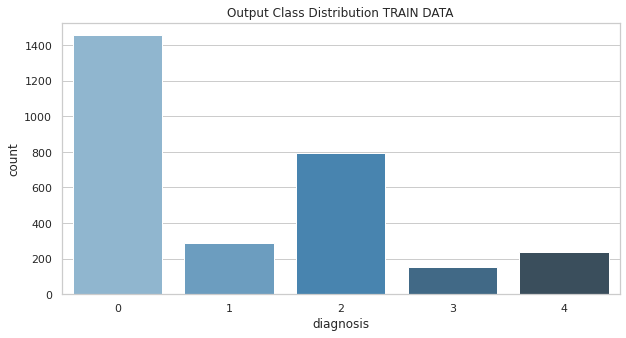

In [8]:
plot_classes(df_train_train,"TRAIN DATA")

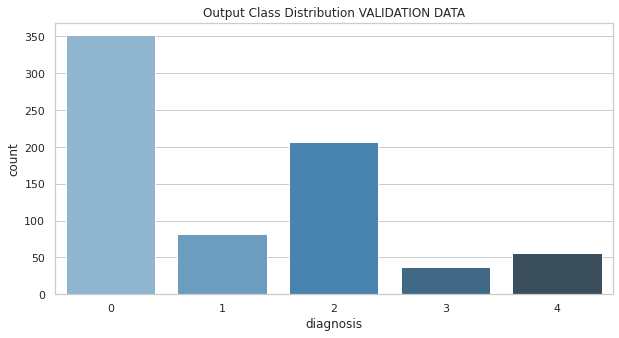

In [9]:
plot_classes(df_train_valid,'VALIDATION DATA')

In [27]:
'''
file = open('df_train_train', 'wb')
pickle.dump(df_train_train, file)
file.close()

file = open('df_train_test', 'wb')
pickle.dump(df_train_test, file)
file.close()
'''

if not os.path.exists(DATASET_PATH + "/train_images_resized_preprocessed"):
  os.mkdir(DATASET_PATH + "/train_images_resized_preprocessed")

if not os.path.exists(DATASET_PATH + "/test_images_resized_preprocessed"):
  os.mkdir(DATASET_PATH + "/test_images_resized_preprocessed")

if not os.path.exists(DATASET_PATH + "/train_images_resized"):
  os.mkdir(DATASET_PATH + "/train_images_resized")

if not os.path.exists(DATASET_PATH + "/test_images_resized"):
  os.mkdir(DATASET_PATH + "/test_images_resized")

In [11]:
file = open('df_train_train', 'rb')
df_train_train = pickle.load(file)
file.close()

file = open('df_train_test', 'rb')
df_train_test = pickle.load(file)
file.close()

In [12]:
print(df_train_train.shape,df_train_test.shape)
print(len(os.listdir('./train_images_resized_preprocessed')),len(os.listdir('./test_images_resized_preprocessed')))

(2929, 4) (1099, 4)
0 0


#  <a id = 'section7'> <font color='red'>  7. Resize and Save</font> </a>

In [13]:
IMG_SIZE  = 512

In [29]:
'''Function loads an image from Folder , Resizes and saves in another directory '''

def train_image_resize_save(file):
    input_filepath = os.path.join('./','train_images','{}.png'.format(file))
    output_filepath = os.path.join('./','train_images_resized','{}.png'.format(file))
    img = cv2.imread(input_filepath)
    cv2.imwrite(output_filepath, cv2.resize(img, (IMG_SIZE,IMG_SIZE)))

def test_image_resize_save(file):
    input_filepath = os.path.join('./','train_images','{}.png'.format(file))
    output_filepath = os.path.join('./','test_images_resized','{}.png'.format(file))
    img = cv2.imread(input_filepath)
    cv2.imwrite(output_filepath, cv2.resize(img, (IMG_SIZE,IMG_SIZE)))

In [30]:
'''This Function uses Multi processing for faster saving of images into folder'''

def train_multiprocess_image_downloader(process:int, imgs:list):
    """
    Inputs:
        process: (int) number of process to run
        imgs:(list) list of images
    """
    print(f'MESSAGE: Running {process} process')
    results = ThreadPool(process).map(train_image_resize_save, imgs)
    return results

def test_multiprocess_image_downloader(process:int, imgs:list):
    """
    Inputs:
        process: (int) number of process to run
        imgs:(list) list of images
    """
    print(f'MESSAGE: Running {process} process')
    results = ThreadPool(process).map(test_image_resize_save, imgs)
    return results

In [31]:
# Use 4 cores
train_multiprocess_image_downloader(4, list(df_train_train.id_code.values))
test_multiprocess_image_downloader(4, list(df_train_test.id_code.values))

MESSAGE: Running 4 process
MESSAGE: Running 4 process


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

##### Summary - Using Multiprocessing (6 cores), we managed to resize and save images within 10 minutes, and reducing IMG_SIZE to 512, thereby reducing disk-space from 20 GB (earlier) to 1 GB (after resizing). We shall load data into colab and start training models

#  <a id = 'section8'> <font color='red'>  8. Image Pre Processing and save</font> </a>

In [32]:
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img

def circle_crop(img, sigmaX = 30):   
    """
    Create circular crop around image centre    
    """    
    img = crop_image_from_gray(img)    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    height, width, depth = img.shape    
    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    img=cv2.addWeighted(img,4, cv2.GaussianBlur( img , (0,0) , sigmaX) ,-4 ,128)
    return img 

def train_preprocess_image(file):
    input_filepath = os.path.join('./','train_images_resized','{}.png'.format(file))
    output_filepath = os.path.join('./','train_images_resized_preprocessed','{}.png'.format(file))
    
    img = cv2.imread(input_filepath)
    img = circle_crop(img) 
    cv2.imwrite(output_filepath, cv2.resize(img, (IMG_SIZE,IMG_SIZE)))

def test_preprocess_image(file):
    input_filepath = os.path.join('./','test_images_resized','{}.png'.format(file))
    output_filepath = os.path.join('./','test_images_resized_preprocessed','{}.png'.format(file))
    
    img = cv2.imread(input_filepath)
    img = circle_crop(img) 
    cv2.imwrite(output_filepath, cv2.resize(img, (IMG_SIZE,IMG_SIZE)))

In [34]:
'''This Function uses Multi processing for faster saving of images into folder'''

def train_multiprocess_image_processor(process:int, imgs:list):
    """
    Inputs:
        process: (int) number of process to run
        imgs:(list) list of images
    """
    print(f'MESSAGE: Running {process} process')
    results = ThreadPool(process).map(train_preprocess_image, imgs)
    return results

def test_multiprocess_image_processor(process:int, imgs:list):
    """
    Inputs:
        process: (int) number of process to run
        imgs:(list) list of images
    """
    print(f'MESSAGE: Running {process} process')
    results = ThreadPool(process).map(test_preprocess_image, imgs)
    return results

In [35]:
# Use 4 cores
train_multiprocess_image_processor(4, list(df_train_train.id_code.values))
test_multiprocess_image_processor(4, list(df_train_test.id_code.values))

MESSAGE: Running 4 process
MESSAGE: Running 4 process


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,